# Notebook for calculating IAXO's sensitivity and validating the Asimov data formalism 

In [1]:
import sys
sys.path.append('../src')
from Params import *
from PlotFuncs import *
from Like import *
from AxionFuncs import *
from numpy.random import poisson

### Load in Signal and background distributions for example case $m_a = 0$ eV

In [2]:
# Energy binning
nfine = 10
nE_bins = 500
Ei,E_bins = EnergyBins(0.2,20.0,nfine,nE_bins)

# Signal for Primakoff flux only
m_a = 0.0
Flux10 = AxionFlux_Primakoff_PlasmonCorrection(1e-10,Ei)#+AxionFlux_Lplasmon(1e-10,Ei,B_model_seismic())
Signal_10,Signal_10_0 = BinnedPhotonNumberTable_Vacuum(array([m_a]),Ei,E_bins,Flux10,res_on=True)

# Background distribution (flat down to threshold)
# IAXO benchmark is 10^-8 counts /keV/s/cm^2
Background = BinnedBackgroundEvents(Ei,E_bins,background_level=1e-8)

In [71]:
# Null hypothesis distribution:
n_expts = 500
T0 = ProfileLikelihoodTest_2D_MonteCarlo(0.0,Signal_10[:,0],Background,n_expts=n_expts)

# Alternative hypothesis distribution as a function of g:
ng = 50
gvals = linspace(1.0,6.0,ng)*1e-12
T1 = zeros(shape=n_expts)
T1_05 = zeros(shape=ng)
T1_16 = zeros(shape=ng)
T1_50 = zeros(shape=ng)
T1_84 = zeros(shape=ng)
T1_95 = zeros(shape=ng)
T1_asimov = zeros(shape=ng)
for i in range(0,ng):
    # Monte Carlo case:
    T1 = ProfileLikelihoodTest_2D_MonteCarlo(gvals[i],Signal_10[:,0],Background,n_expts=n_expts)
    
    # Asimov case:
    T1_asimov[i] = ProfileLikelihoodTest_2D_Asimov(gvals[i],Signal_10[:,0],Background)
        
    # Calculate median and 1/2 sigma containing regions of T1 distribution 
    T1_05[i] = sort(T1)[int(0.045*n_expts)]    
    T1_16[i] = sort(T1)[int(0.16*n_expts)]    
    T1_50[i] = sort(T1)[int(0.50*n_expts)]    
    T1_84[i] = sort(T1)[int(0.84*n_expts)]    
    T1_95[i] = sort(T1)[int(0.9545*n_expts)]    

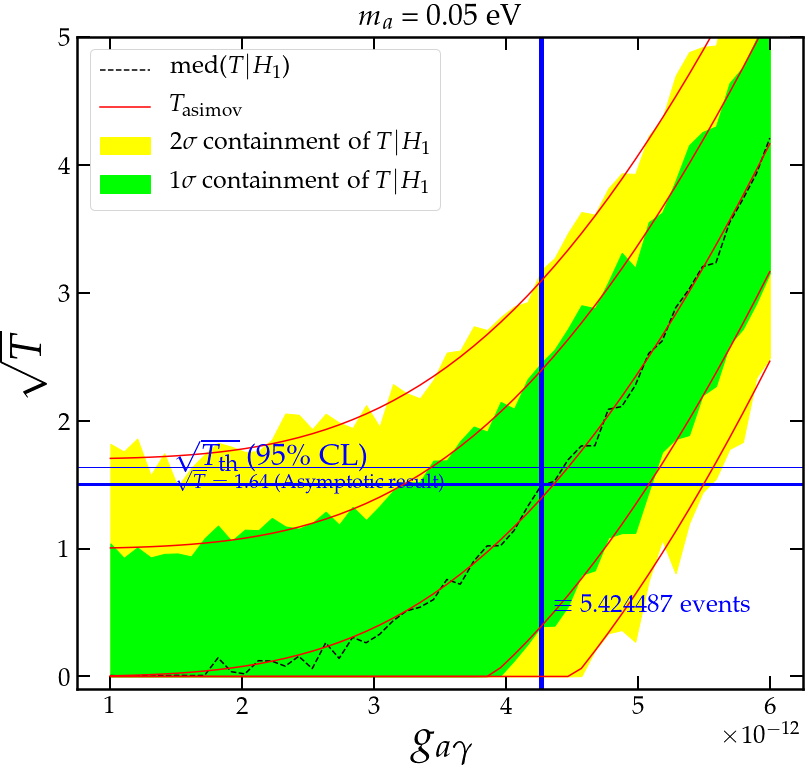

In [73]:
fig,ax = MySquarePlot(r'$g_{a\gamma}$',r'$\sqrt{T}$')

plt.plot(gvals,sqrt(T1_50),'k--',label='med($T|H_1$)')

plt.fill_between(gvals,sqrt(T1_05),y2=sqrt(T1_95),color='yellow',label=r'2$\sigma$ containment of $T|H_1$')
plt.fill_between(gvals,sqrt(T1_16),y2=sqrt(T1_84),color='lime',label=r'1$\sigma$ containment of $T|H_1$')

T0_95 = sort(T0)[int(0.95*n_expts)]
plt.axhline(sqrt(T0_95),color='b',lw=3)
plt.axhline(1.64,color='b',lw=1)
      
            
g95_med = gvals[argmin(abs(T0_95-T1_50))]
plt.axvline(g95_med,color='b',lw=5)

plt.ylim([0,5])

plt.plot(gvals,sqrt(T1_asimov),'r-',label=r'$T_{\rm asimov}$')
plt.plot(gvals,sqrt(T1_asimov)+1,'r-')
plt.plot(gvals,maximum(0,sqrt(T1_asimov)-1),'r-')
plt.plot(gvals,maximum(0,sqrt(T1_asimov)-1.7),'r-')
plt.plot(gvals,sqrt(T1_asimov)+1.7,'r-')

plt.legend()

plt.text(1.5e-12,sqrt(T0_95)+0.1,r'$\sqrt{T_{\rm th}}$ (95\% CL)',color='blue',fontsize=30)
plt.text(1.5e-12,1.64-0.17,r'$\sqrt{T}=1.64$ (Asymptotic result)',color='blue',fontsize=20)

plt.title(r'$m_a$ = '+str(m_a)+' eV')

N_events = sum(Signal_10[:,0])*(g95_med/1e-10)**4.0
plt.text(g95_med+0.1e-12,0.5,r'$\equiv$ '+str('{0:0f}'.format(N_events))+' events',color='b')

plt.ylim(bottom=-0.1)

MySaveFig(fig,'IAXO_AsimovValidation')

# We can see that the Asimov data works well for calculating the limit at $m_a$ let's now repeat the process for a range of masses to calculate the sensitivity 

In [59]:
# Range of masses
nm = 1000
m_vals = logspace(-6.1,0.1,nm)

# Energy binning
nfine = 10
nE_bins = 500
Ei,E_bins = EnergyBins(10e-3,20.0,nfine,nE_bins)


# Primakoff Signal
Flux10 = AxionFlux_Primakoff_PlasmonCorrection(1e-10,Ei)
Signal_10,R0 = BinnedPhotonNumberTable_AllModes(m_vals,Ei,E_bins,Flux10,Exposure_total=6.0,res_on=False)


# Signal for LPlasmon flux
Flux10_1 = AxionFlux_Lplasmon(1e-10,Ei,B_model_seismic())
Signal_10_1,R0_1 = BinnedPhotonNumberTable_AllModes(m_vals,Ei,E_bins,Flux10_1,Exposure_total=6.0,res_on=False)


# Background
Background = BinnedBackgroundEvents(Ei,E_bins,background_level=1e-8)

In [60]:
 
n_DL = 500
m_DL_vals = logspace(-6,0,n_DL)
DL = ProfileLikelihood_Sensitivity(m_DL_vals,m_vals,Signal_10,Background)
DL_1 = ProfileLikelihood_Sensitivity(m_DL_vals,m_vals,Signal_10+Signal_10_1,Background)


In [61]:
DL_MC = ProfileLikelihood_Sensitivity_MonteCarlo(m_DL_vals,m_vals,Signal_10,Background)

0 4.360492906887946e-12
1 4.540381255604875e-12
2 4.518499457531756e-12
3 4.5614817099107294e-12
4 4.5672779850476716e-12
5 4.479741154441825e-12
6 4.274944477468723e-12
7 4.4740318159904315e-12
8 4.4120222212151334e-12
9 4.433961399793586e-12
10 4.457991686663586e-12
11 4.451715702931474e-12
12 4.600383459155335e-12
13 4.469503814769636e-12
14 4.52200581401019e-12
15 4.575063147529076e-12
16 4.6220838492836255e-12
17 4.367550265674642e-12
18 4.4755176604136895e-12
19 4.4339221111214225e-12
20 4.532920612016134e-12
21 4.2749444774687235e-12
22 4.59693290976699e-12
23 4.456878971960153e-12
24 4.554594741237946e-12
25 4.490051931414248e-12
26 4.4461905232549465e-12
27 4.379085124958695e-12
28 4.58516139488242e-12
29 4.7016406978437535e-12
30 4.333822487997223e-12
31 4.447720156785512e-12
32 4.485985008669711e-12
33 4.486430480459694e-12
34 4.451906963318762e-12
35 4.441823038947086e-12
36 4.450005459814959e-12
37 4.588599764963716e-12
38 4.582636083294935e-12
39 4.465243301670159e-12
40 

318 4.519837081844584e-12
319 4.411742432360825e-12
320 4.49164147547571e-12
321 4.401961971614436e-12
322 4.587649838262031e-12
323 4.61043349302003e-12
324 4.623179908549867e-12
325 4.587184659448981e-12
326 4.573811758194281e-12
327 4.614586128813411e-12
328 4.608857815492378e-12
329 4.735399667017256e-12
330 4.57335774048066e-12
331 4.637938539192641e-12
332 4.6965746803978026e-12
333 4.772509408191288e-12
334 4.755865760216634e-12
335 4.7115435972396215e-12
336 4.868045494530935e-12
337 4.865404371448138e-12
338 5.035623634351064e-12
339 4.867134788531224e-12
340 5.0326951543095974e-12
341 5.2376253011959435e-12
342 5.113092102428413e-12
343 5.042077657019763e-12
344 5.30584822556364e-12
345 5.251002722600799e-12
346 5.206920971469448e-12
347 5.554999309267349e-12
348 5.659081971710768e-12
349 5.745112090990399e-12
350 6.049158179901143e-12
351 5.911001464159244e-12
352 6.364247686626878e-12
353 6.317558239160738e-12
354 6.276953325427547e-12
355 6.574617230471799e-12
356 6.861394

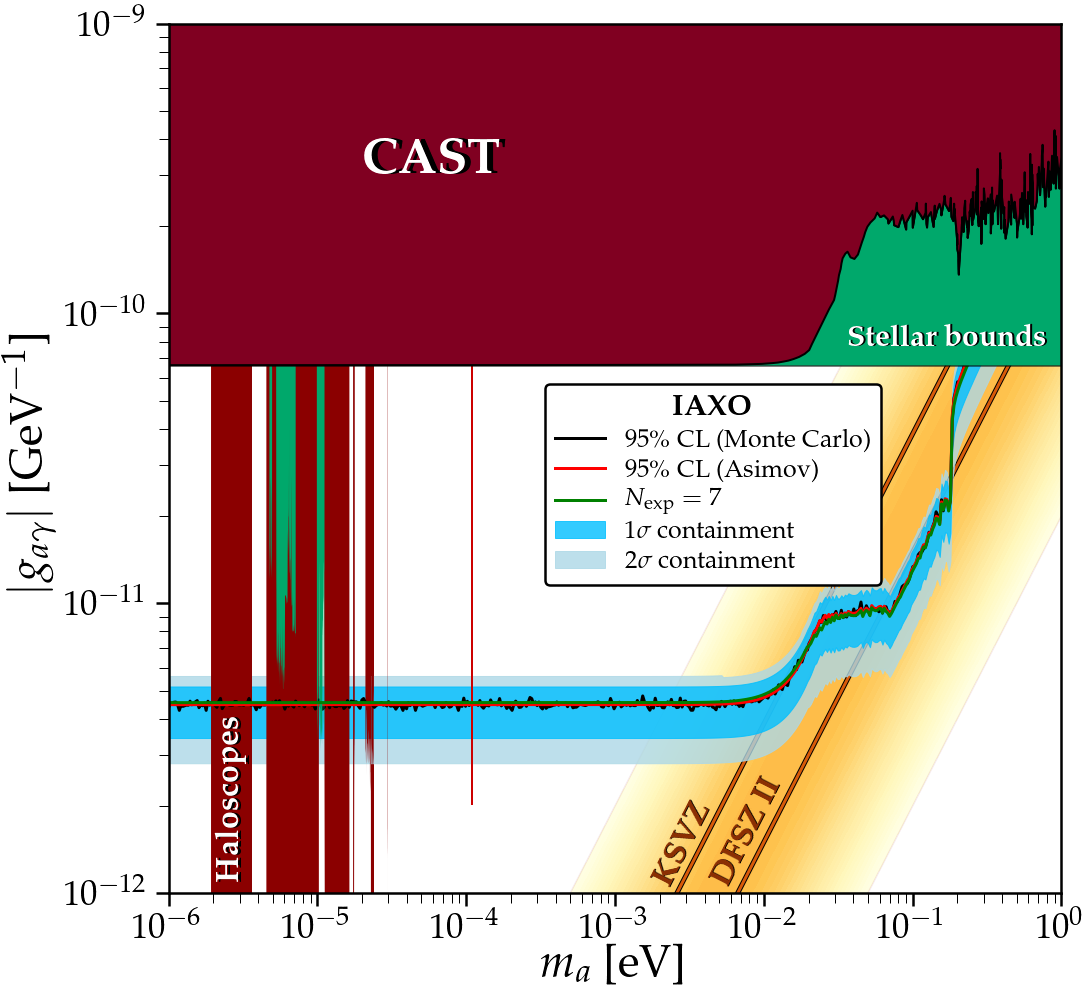

In [74]:
fig,ax = AxionPlotSetup()


plt.plot(m_DL_vals,DL_MC,'k-',lw=3,zorder=0.1,label=r'95\% CL (Monte Carlo)')
plt.plot(m_DL_vals,DL[0,:],'r-',lw=3,zorder=0.1,label=r'95\% CL (Asimov)')
plt.fill_between(m_DL_vals,DL[1,:],y2=DL[2,:],color='deepskyblue',zorder=0.02,label='$1\sigma$ containment',alpha=0.8)
plt.fill_between(m_DL_vals,DL[3,:],y2=DL[4,:],color='lightblue',zorder=0.01,label='$2\sigma$ containment',alpha=0.8)

#plt.plot(m_DL_vals,DL_1[0,:],'k--',lw=3,zorder=0.1,label=r'$\quad$+LPlasmon flux')


IAXO_approx = ConstantObsNumberLine(7,m_DL_vals,m_vals,Signal_10) # Primakoff 
plt.plot(m_DL_vals,IAXO_approx,'g-',lw=3,label=r'$N_{\rm exp} = 7$',zorder=0.11)

leg = plt.legend(fontsize=25,frameon=True,title=r'{\bf IAXO}',loc='center',framealpha=1,edgecolor='k',labelspacing=0.2,bbox_to_anchor=(0.61,0.47))
plt.setp(leg.get_title(),fontsize=30)
leg.get_frame().set_linewidth(2.5)

MySaveFig(fig,'IAXO_Sensitivity_Asimov')